In [46]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import data_visualization as dv
import dill
import scipy 
from scipy.stats import norm
from scipy import stats
import sys
import importlib
import pingouin as pg
import pandas as pd
import analysis_utilities as au
from itertools import combinations
from IPython.display import display

'''
Using function now instead of writing things over and over again 
'''

'\nUsing function now instead of writing things over and over again \n'

In [47]:
sys.path.insert(0,r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import plot_functions 
import Subject_Object_v2
importlib.reload(Subject_Object_v2)
importlib.reload(plot_functions)
import plot_functions as pf
import read_data_functions as rdf
import Statistics_Object
importlib.reload(Statistics_Object)

<module 'Statistics_Object' from 'd:\\onedrive - university of delaware - o365\\desktop\\matchpennies-agent-expirement\\src\\Statistics_Object.py'>

## Initial Thangs

In [48]:
experiment = 'Exp1'

In [49]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f'D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}')
PATH = os.getcwd()
SAVE_PATH = f'C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Group_Figures\\{experiment}\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)

if experiment == 'Exp1':
    tp3_title = "1000 [50]"
    tp4_title = "1000 [150]"
    tp5_title = '1100 [50]'
    tp6_title = "1100 [150]"
    tp7_title = "1200 [50]"
    tp8_title = '1200 [150]'
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
    xlabel = 'Agent Mean [SD] Movement Onset Time (ms)'
    num_blocks = len(trial_block_titles)
    num_trials = 80
    num_rows,num_cols = 2,3
    condition_nums = ['0','1','2','3','4','5']
    f1_xlabel = 'Agent Mean Movement Onset Time (ms)'
    f2_xlabel = 'Agent SD Movement Onset Time (ms)'
    f1_collapse_xticklabs = ['1000','1100','1200']
    f2_collapse_xticklabs = ['50','150']
    
if experiment == 'Exp2':
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = 'Feedback Condition'
    condition_nums = ['0','1','2','3']

    num_trials = 80
    num_rows,num_cols = 2,2
    f1_xlabel = 'Incorrect Reward'
    f2_xlabel = 'Indecision Reward'
    f1_collapse_xticklabs = ['0 Incorrect','-1 Incorrect']
    f2_collapse_xticklabs = ['0 Indecision','-1 Indecision']
    


## Pickle Objects

In [50]:
load_path = r'Subjects_Analyzed'
subject_objects = rdf.generate_subject_objects(experiment)
group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2, 
                                    task_leave_time_metric_name = 'player_velocity_task_leave_time_thresh',task_movement_time_metric_name = 'player_velocity_task_movement_time_thresh',
                                    reaction_time_metric_name = 'player_velocity_reaction_time_thresh', reaction_movement_time_metric_name = 'player_velocity_reaction_movement_time_thresh')
group.analyze_data()

Sub1
Sub2
Sub3
Sub4
Sub5
Sub6
Sub7
Sub8
Sub9
Sub10
Sub11
Sub12
Sub13
Sub14
Sub15
Sub16
Sub17
Sub18
Sub19
Sub20


D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Subject_Object_v2.py:492: RuntimeWarning: All-NaN slice encountered
  self.init_reach_posx_single_timepoint = np.nanmax(self.init_reach_posx*self.init_reach_pos_mask,axis=2)
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Subject_Object_v2.py:557: RuntimeWarning: divide by zero encountered in true_divide
  self.mu_s = (self.phat_correct*self.mhat_correct - self.phat_error*self.mhat_error)/(self.phat_correct - self.phat_error)
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Subject_Object_v2.py:568: RuntimeWarning: divide by zero encountered in true_divide
  self.mu_s_alternate = (self.phat_correct*self.mhat_correct_alternate - self.phat_error*self.mhat_error_alternate)/(self.phat_correct - self.phat_error)


## Set Save to True or False

In [51]:
save = False

## Create DataFrame for Pingouin

In [52]:
wins                 = group.player_perc_wins.flatten().tolist()
indecisions          = group.player_perc_indecisions.flatten().tolist()
incorrects           = group.player_perc_incorrects.flatten().tolist()
correct_decisions    = np.array(group.phat_correct*100).flatten().tolist()
median_leave_time    = np.nanmedian(group.player_task_leave_time_nan,axis=2).flatten().tolist()
q1_median_leave_time = np.nanquantile(group.player_task_leave_time_nan,0.25,axis=2).flatten().tolist()
q3_median_leave_time = np.nanquantile(group.player_task_leave_time_nan,0.75,axis=2).flatten().tolist()
leave_time_sd        = np.nanstd(group.player_task_leave_time_nan,axis=2).flatten().tolist()
gamble_leave_time    = np.nanmedian(group.player_gamble_task_leave_time,axis=2).flatten().tolist()
median_movement_time        = np.nanmedian(group.player_task_movement_time,axis=2).flatten().tolist()
reaction_decisions   = group.perc_reaction_decisions.flatten().tolist()
gamble_decisions     = group.perc_gamble_decisions.flatten().tolist()
wins_when_both_decide = group.player_perc_both_reached_wins.flatten().tolist()
subject_number = np.repeat(np.arange(1,num_subjects+1,1,dtype=int),num_blocks).tolist()
condition = np.tile(np.arange(1,num_blocks+1,1,dtype=int),num_subjects).tolist()
# alt_condition = np.tile(['1000 (50)','1000 (150)','1100 (50)','1100 (150)', '1200 (50)', '1200 (150)'],num_subjects).tolist()
if experiment == 'Exp1':
    factor1 = np.tile(['1000','1000','1100','1100','1200','1200'],num_subjects) 
    factor2 = np.tile(['50','150'],num_subjects*3)    
    points = np.full_like(wins,0)
else:
    factor1 = np.tile(['0 Inc','-1 Inc','0 Inc','-1 Inc'],num_subjects) 
    factor2 = np.tile(['0 Ind','0 Ind','-1 Ind','-1 Ind'],num_subjects) 
    points = group.player_points_scored.flatten().tolist()
    decision_time_difference_punish_incorrects = np.nanmedian(group.player_task_leave_time_nan,axis=2)[0] - np.nanmedian(group.player_task_leave_time_nan,axis=2)[1] 
    decision_time_difference_punish_indecisions = np.nanmedian(group.player_task_leave_time_nan,axis=2)[0] - np.nanmedian(group.player_task_leave_time_nan,axis=2)[2]  
df_metrics = pd.DataFrame(np.array([median_leave_time,median_movement_time,wins,indecisions,incorrects,correct_decisions,wins_when_both_decide,
                                    gamble_leave_time,leave_time_sd,q1_median_leave_time,q3_median_leave_time,
                                    reaction_decisions,gamble_decisions,points]).T,
                        columns=['Median Leave Time','Median Movement Time','Wins','Indecisions','Incorrects','Correct Decisions','Wins When Both Decide',
                                 'Median Gamble Leave Time','SD Leave Time','Q1 Leave Time','Q3 Leave Time','Reaction Decisions','Gamble Decisions','Points'])
df_conditions = pd.DataFrame(np.array([subject_number,condition,factor1,factor2]).T,columns = ['Subject','Condition','Factor 1','Factor 2'])
# df_metrics.astype('float64')

# df = df.astype({'Subject':'int32','Condition':'int32','Condition Mean':'int32','Condition SD':'int32'})
# dill.dump(df,open(save_path+'\\metrics_df_all_subjects.pkl','wb')) 
df = pd.concat([df_conditions,df_metrics],axis=1)
# assert ~df.isnull().any(axis=1).any(),('NaN Values found in dataframe')
display(df.iloc[6:12])

,Subject,Condition,Factor 1,Factor 2,Median Leave Time,Median Movement Time,Wins,Indecisions,Incorrects,Correct Decisions,Wins When Both Decide,Median Gamble Leave Time,SD Leave Time,Q1 Leave Time,Q3 Leave Time,Reaction Decisions,Gamble Decisions,Points
6,2,1,1000,50,1234.0,142.0,90.00,1.25,8.75,88.75,91.139241,1142.0,66.372847,1195.75,1270.75,77.50,22.50,0.0
7,2,2,1000,150,1211.5,145.5,86.25,8.75,5.00,88.75,94.520548,1252.0,91.211203,1164.50,1278.50,81.25,18.75,0.0
8,2,3,1100,50,1307.5,148.5,53.75,20.00,26.25,62.50,67.187500,1265.0,64.764014,1252.75,1339.00,46.25,53.75,0.0
9,2,4,1100,150,1216.0,159.0,65.00,16.25,18.75,66.25,76.923077,1186.0,95.838666,1169.50,1278.00,48.75,51.25,0.0
10,2,5,1200,50,1300.0,142.0,37.50,32.50,30.00,56.25,55.555556,1282.0,109.411197,1213.75,1372.25,22.50,77.50,0.0
11,2,6,1200,150,1279.0,143.0,53.75,22.50,23.75,61.25,65.454545,1244.0,93.821465,1185.75,1344.25,38.75,61.25,0.0


## Initialize bootstrap

In [53]:
so = Statistics_Object.Statistics(df, experiment = experiment, num_subjects=num_subjects,num_blocks=num_blocks,num_trials=num_trials,trial_block_titles=trial_block_titles,
                                  xlab =xlabel, f1_xticklabels=f1_collapse_xticklabs,f2_xticklabels=f2_collapse_xticklabs,f1_xlabel=f1_xlabel,f2_xlabel=f2_xlabel,
                                  M = 1e6)

In [54]:
_,b = so.run_statistics('Median Leave Time',change_m=1e2)
_,b = so.run_statistics('Median Leave Time',change_m=1e2,test='median')

Non-significant interaction, collapsing across conditions...
Non-significant interaction, collapsing across conditions...


## Median Leave Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,59699.487500,2,38,29849.743750,4.360600,0.019730,0.030075,0.031095,0.775649
1,Factor 2,66811.602083,1,19,66811.602083,6.815716,0.017188,0.017188,0.034671,1.000000
2,Factor 1 * Factor 2,2723.429167,2,38,1361.714583,0.521157,0.598016,0.565215,0.001462,0.828255


Collapsing, changed select conditions to be All


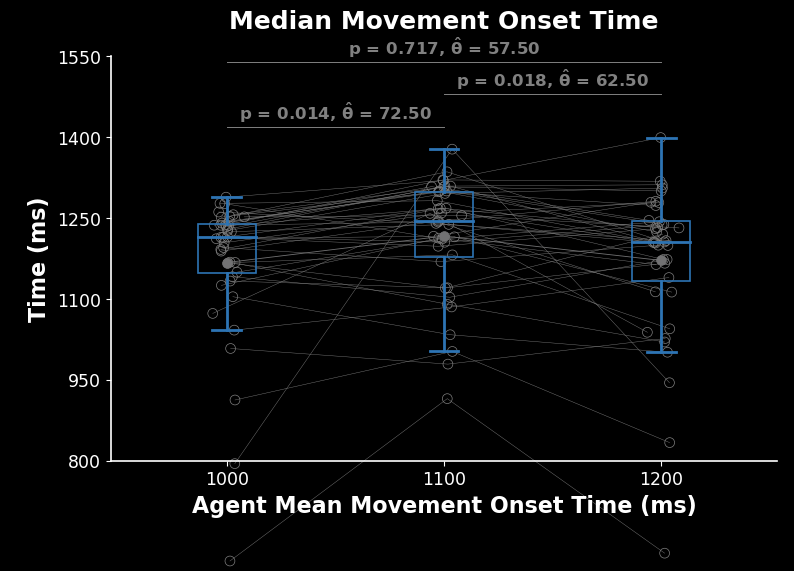

Collapsing, changed select conditions to be All


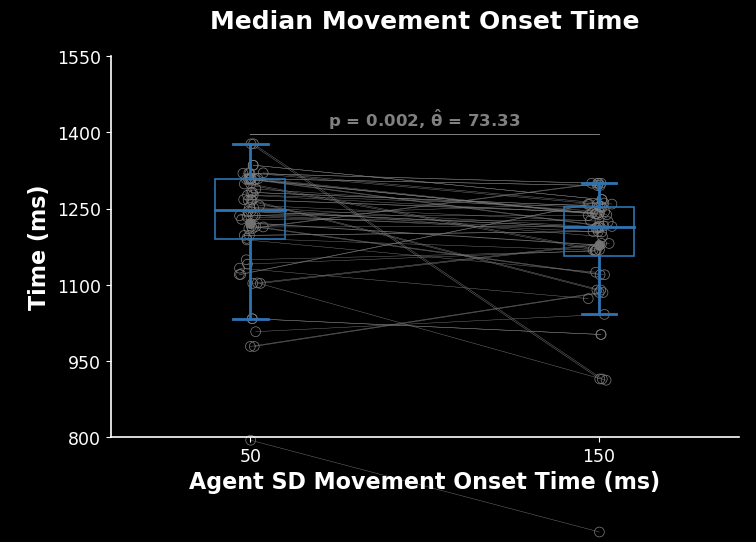

In [55]:
median_leave_time_anova,median_leave_time_statistics = so.run_statistics('Median Leave Time')
display(median_leave_time_anova)
so.plot(median_leave_time_statistics,'Median Leave Time',title='Median Movement Onset Time',
                    ylab='Time (ms)',title_pad = 20,ylocs=np.arange(800,1650,150),lims=True)

## Median Movement Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,2125.866667,2,38,1062.933333,3.238191,0.050284,0.053796,0.008276,0.940366
1,Factor 2,567.675000,1,19,567.675000,2.769686,0.112471,0.112471,0.002223,1.000000
2,Factor 1 * Factor 2,785.850000,2,38,392.925000,2.016365,0.147138,0.149332,0.003075,0.959217


!! Factor 1 is not significant !!
!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


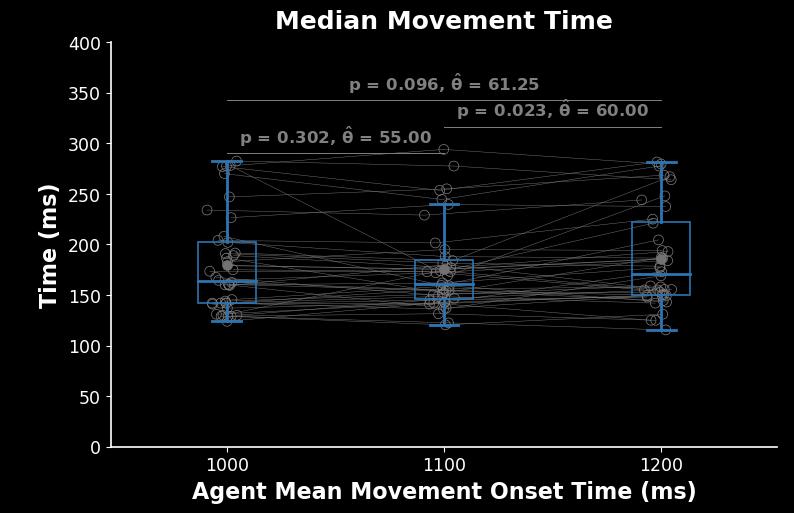

Collapsing, changed select conditions to be All


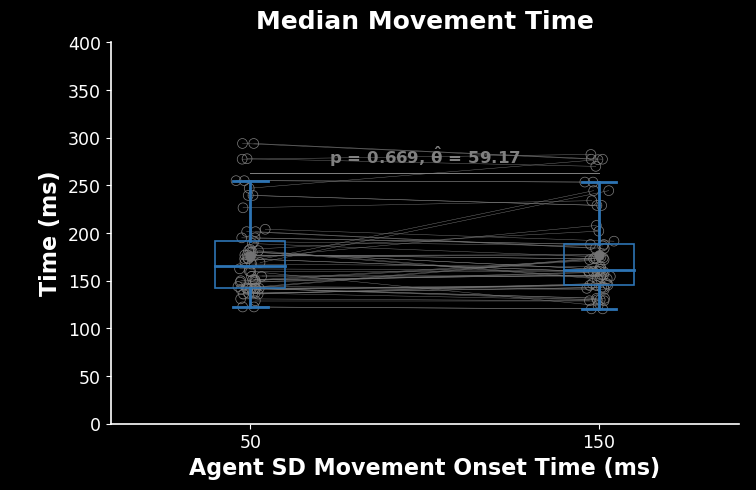

In [56]:
median_movement_time_anova,median_movement_time_statistics = so.run_statistics('Median Movement Time')
display(median_movement_time_anova)
so.plot(median_movement_time_statistics,'Median Movement Time',title='Median Movement Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,50),lims=True)

## SD Leave Times

Interaction significance close
Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,15203.650706,2,38,7601.825353,5.501936,0.007971,0.018015,0.041648,0.691673
1,Factor 2,10047.983589,1,19,10047.983589,20.361034,0.000238,0.000238,0.027919,1.000000
2,Factor 1 * Factor 2,3851.588749,2,38,1925.794374,2.485900,0.096694,0.097401,0.010889,0.988805


Collapsing, changed select conditions to be All


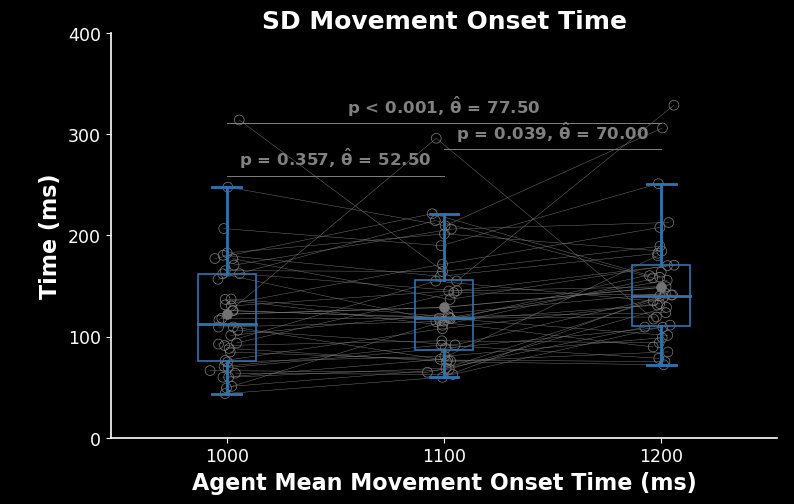

Collapsing, changed select conditions to be All


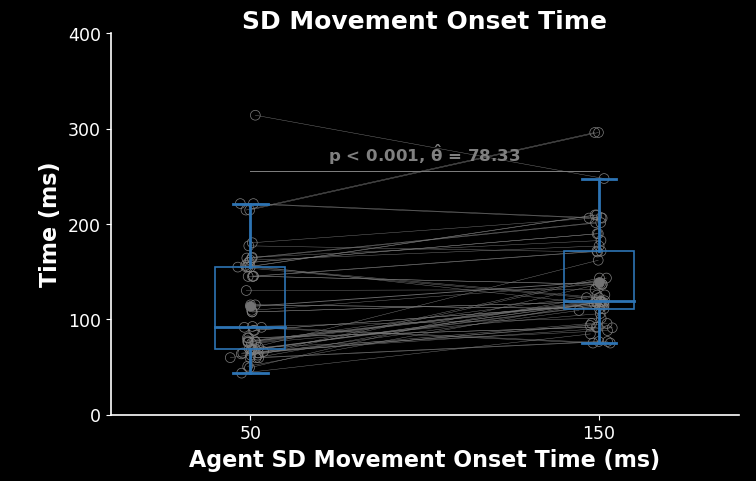

In [57]:
sd_leave_time_anova,sd_leave_time_statistics = so.run_statistics('SD Leave Time')
display(sd_leave_time_anova)
so.plot(sd_leave_time_statistics,'SD Leave Time',title='SD Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,100),title_pad = 0,lims=True,cut_pvals=False)

## First Quartile Leave Time

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,78363.309375,2,38,39181.654688,3.509859,0.039924,0.060757,0.027044,0.679355
1,Factor 2,106341.417187,1,19,106341.417187,13.221540,0.001758,0.001758,0.036349,1.000000
2,Factor 1 * Factor 2,152.534375,2,38,76.267188,0.017130,0.983023,0.967998,0.000054,0.819503


!! Factor 1 is not significant !!
Collapsing, changed select conditions to be All


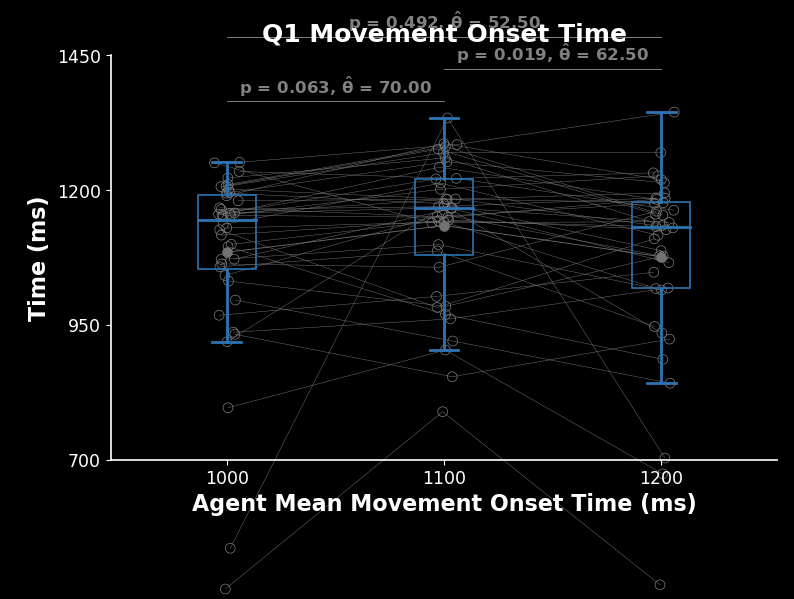

Collapsing, changed select conditions to be All


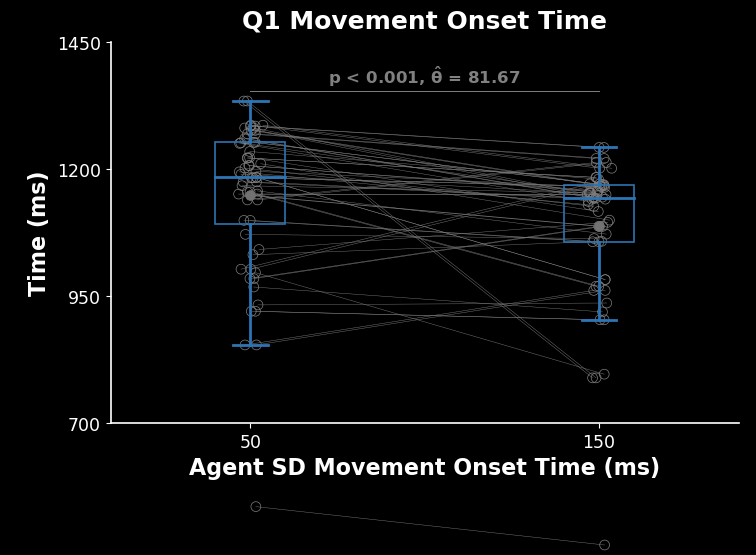

In [58]:
q1_leave_time_anova,q1_leave_time_statistics = so.run_statistics('Q1 Leave Time')
display(q1_leave_time_anova)
so.plot(q1_leave_time_statistics,'Q1 Leave Time',title='Q1 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(700,1600,250),lims=True)

## Third Quartile Leave Time

Interaction significance close
Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,54141.196875,2,38,27070.598437,6.287434,0.004377,0.006381,0.044117,0.880327
1,Factor 2,33659.125521,1,19,33659.125521,4.075297,0.057854,0.057854,0.027892,1.000000
2,Factor 1 * Factor 2,13723.344792,2,38,6861.672396,3.150109,0.054222,0.064446,0.011563,0.839156


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


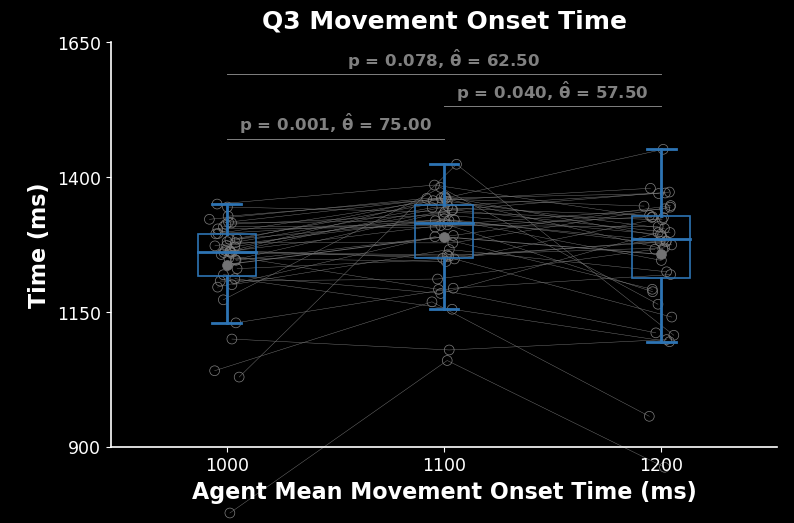

Collapsing, changed select conditions to be All


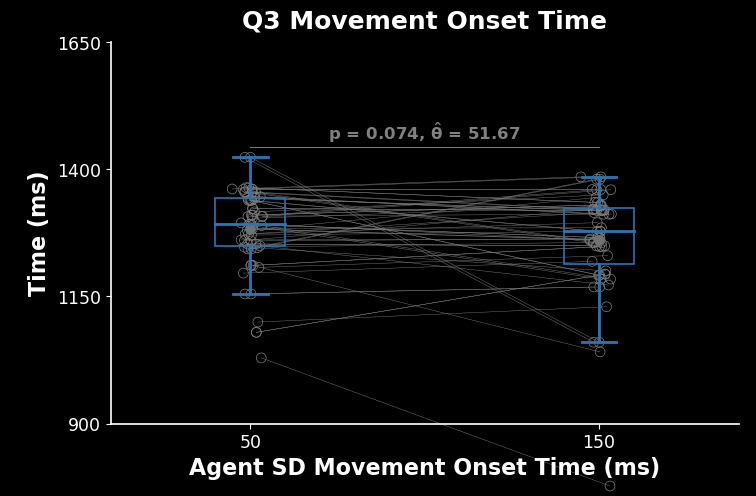

In [59]:
q3_leave_time_anova,q3_leave_time_statistics = so.run_statistics('Q3 Leave Time')
display(q3_leave_time_anova)
so.plot(q3_leave_time_statistics,'Q3 Leave Time',title='Q3 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(900,1700,250),lims=True)

## Correct Decisions (Doesn't matter if indecision)

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,13546.2500,2,38,6773.12500,61.623005,1.184671e-12,8.905946e-10,0.495714,0.726568
1,Factor 2,541.8750,1,19,541.87500,14.053462,1.359712e-03,1.359712e-03,0.037834,1.000000
2,Factor 1 * Factor 2,50.9375,2,38,25.46875,0.442197,6.458877e-01,6.111892e-01,0.003683,0.834927


Collapsing, changed select conditions to be All


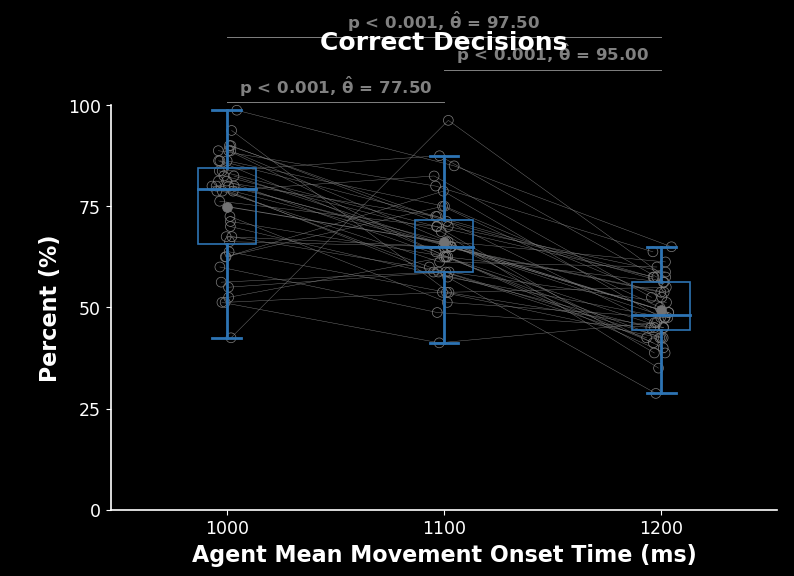

Collapsing, changed select conditions to be All


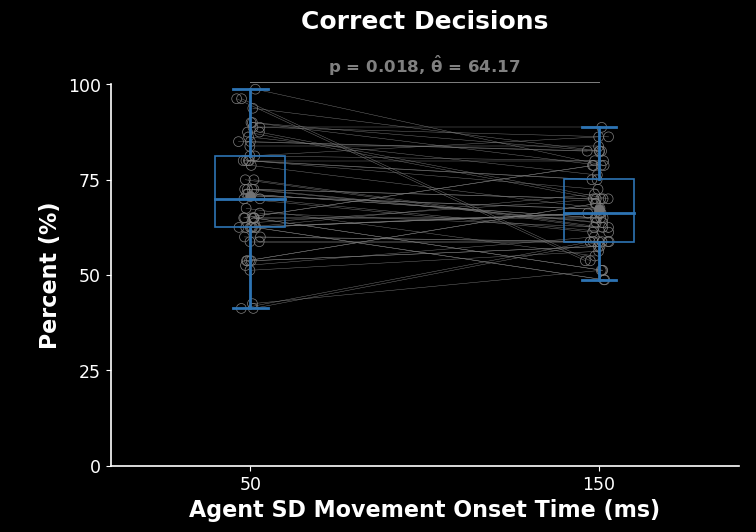

In [60]:
corrects_anova,corrects_statistics = so.run_statistics('Correct Decisions')
display(corrects_anova)
so.plot(corrects_statistics,'Correct Decisions',title='Correct Decisions',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

## Wins When Both Decide

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,13212.565230,2,38,6606.282615,51.429964,1.544993e-11,3.645969e-10,0.391424,0.854103
1,Factor 2,33.811980,1,19,33.811980,0.606323,4.457657e-01,4.457657e-01,0.001643,1.000000
2,Factor 1 * Factor 2,319.749092,2,38,159.874546,1.828819,1.744577e-01,1.772794e-01,0.015327,0.936370


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


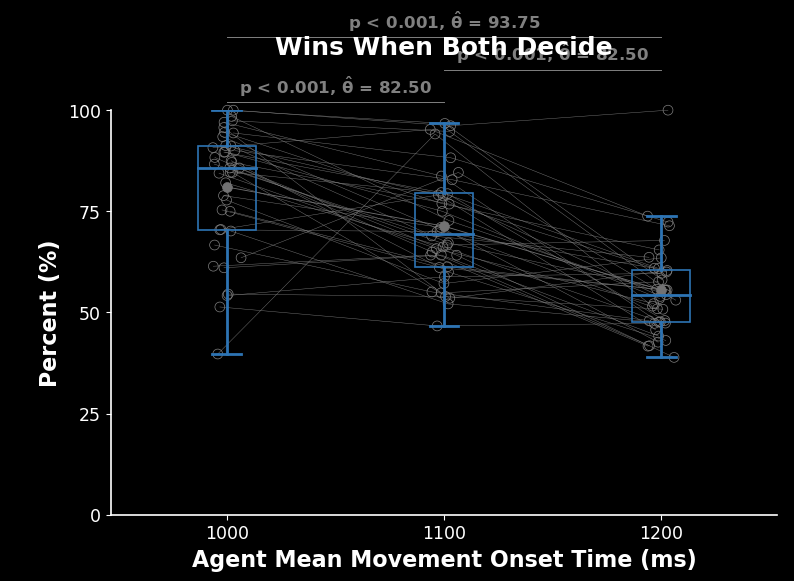

Collapsing, changed select conditions to be All


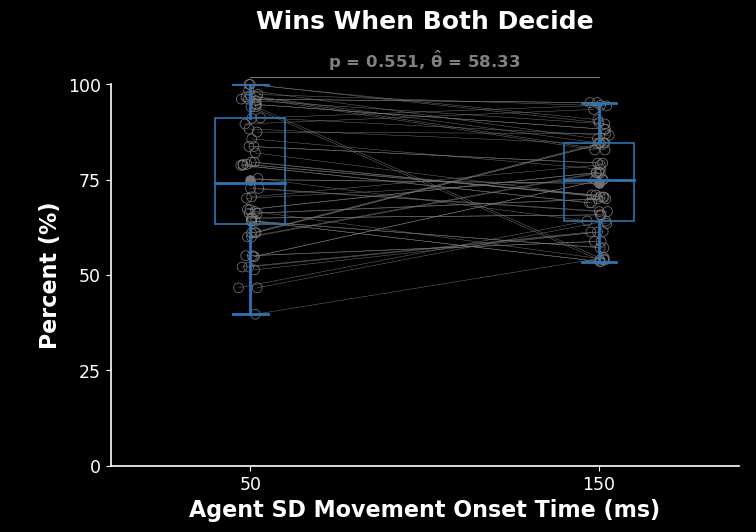

In [61]:
wins_when_both_decide_anova,wins_when_both_decide_statistics = so.run_statistics('Wins When Both Decide')
display(wins_when_both_decide_anova)
so.plot(wins_when_both_decide_statistics,'Wins When Both Decide',title='Wins When Both Decide',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

# Points Scored

In [62]:
if experiment == 'Exp2':
    points_anova,points_statistics = so.run_statistics('Points')
    display(points_anova)
    so.plot(points_statistics,'Points',title='Points',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=20,h=1,cut_pvals=False)

## Wins

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,13373.671875,2,38,6686.835938,51.777019,1.407231e-11,2.670757e-09,0.501585,0.759118
1,Factor 2,579.700521,1,19,579.700521,8.951407,7.495068e-03,7.495068e-03,0.041799,1.000000
2,Factor 1 * Factor 2,2636.119792,2,38,1318.059896,23.729079,2.053863e-07,3.546155e-06,0.165531,0.770944


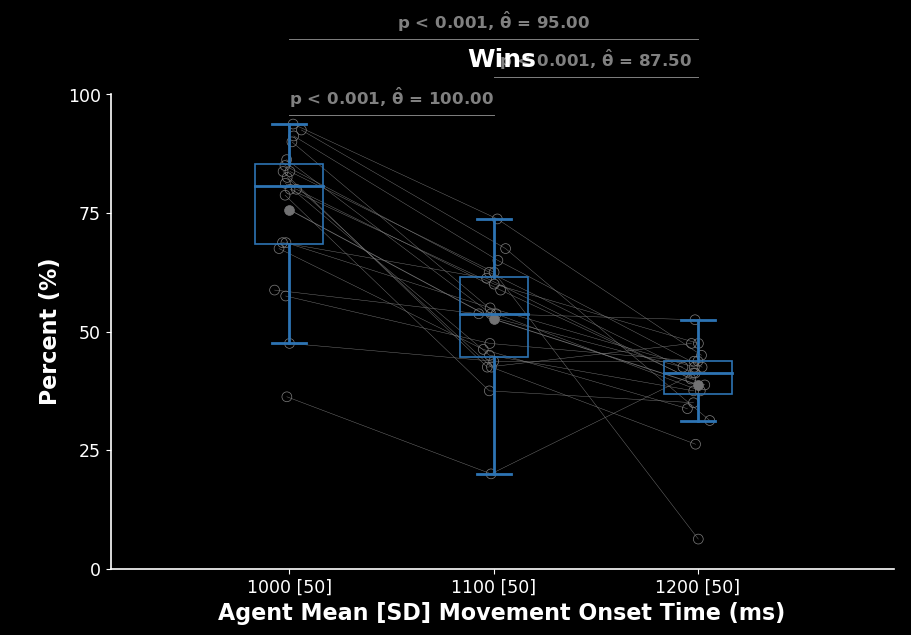

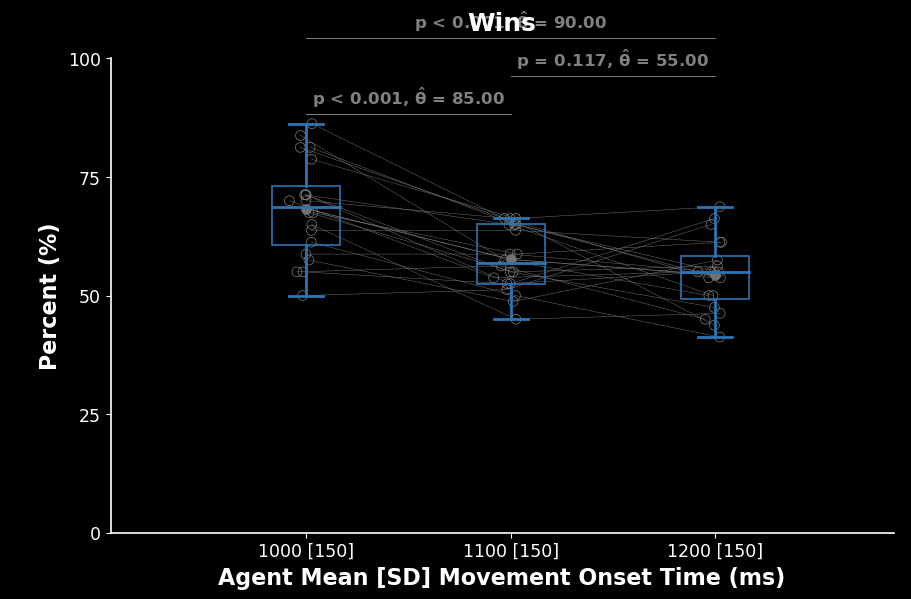

In [63]:
wins_anova,wins_statistics = so.run_statistics('Wins')
display(wins_anova)
so.plot(wins_statistics,'Wins',title='Wins',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=20,h=1,cut_pvals=False)

## Incorrects

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,5953.854167,2,38,2976.927083,29.795407,1.648612e-08,1.588739e-07,0.246655,0.847537
1,Factor 2,157.552083,1,19,157.552083,2.522493,1.287353e-01,1.287353e-01,0.008590,1.000000
2,Factor 1 * Factor 2,556.354167,2,38,278.177083,3.722088,3.340427e-02,4.280908e-02,0.029687,0.829146


!! Factor 2 is not significant !!


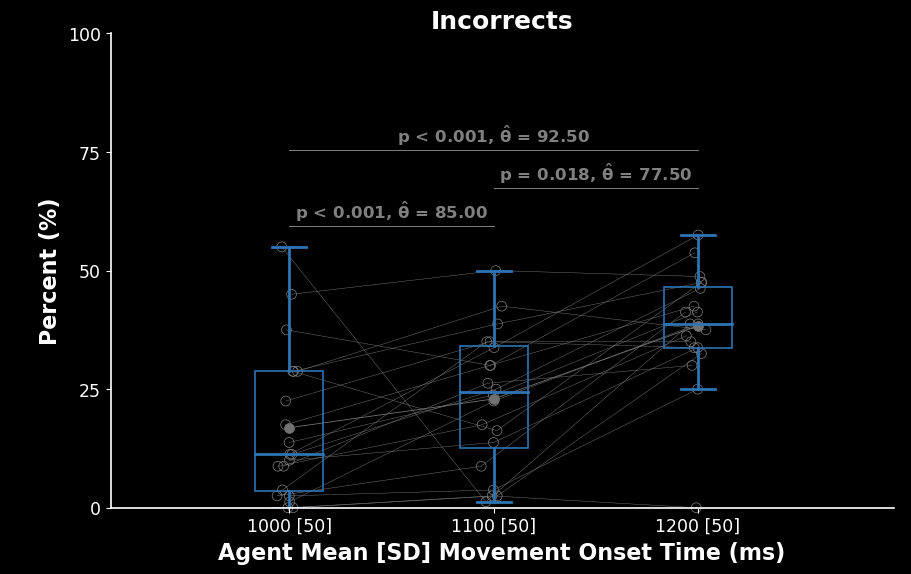

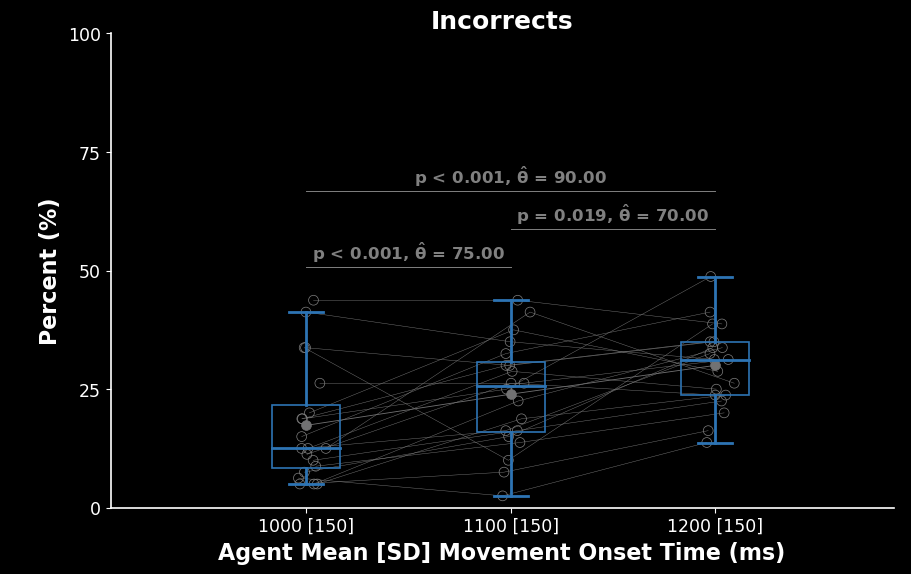

In [64]:
incorrects_anova,incorrects_statistics = so.run_statistics('Incorrects',test='median')
display(incorrects_anova)
so.plot(incorrects_statistics,'Incorrects',title='Incorrects',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=0,h=0.5,
                cut_pvals = False)

In [68]:
group.player_perc_indecisions

array([[ 3.75, 17.5 , 16.25,  5.  ,  3.75, 18.75],
       [ 1.25,  8.75, 20.  , 16.25, 32.5 , 22.5 ],
       [ 3.75,  8.75, 33.75, 10.  , 32.5 ,  5.  ],
       [ 7.5 , 11.25,  6.25, 13.75,  7.5 , 20.  ],
       [ 6.25, 12.5 , 23.75, 20.  , 22.5 , 11.25],
       [ 8.75,  7.5 , 10.  , 31.25, 23.75,  6.25],
       [16.25, 32.5 , 35.  , 47.5 , 93.75, 45.  ],
       [ 2.5 , 11.25, 22.5 ,  8.75, 12.5 ,  7.5 ],
       [ 5.  , 11.25, 28.75, 35.  , 43.75, 33.75],
       [ 3.75, 23.75, 32.5 , 22.5 , 13.75, 18.75],
       [ 3.75, 23.75, 11.25, 21.25, 28.75,  7.5 ],
       [18.75, 21.25, 17.5 , 18.75, 13.75, 20.  ],
       [ 8.75,  1.25, 78.75,  3.75, 20.  ,  6.25],
       [16.25, 16.25, 46.25, 18.75, 21.25, 17.5 ],
       [ 2.5 , 10.  , 11.25, 10.  , 18.75,  7.5 ],
       [12.5 , 27.5 , 22.5 , 40.  , 17.5 , 20.  ],
       [ 3.75,  3.75,  3.75,  2.5 ,  1.25,  3.75],
       [10.  , 22.5 , 37.5 , 25.  , 18.75, 16.25],
       [ 0.  ,  6.25, 17.5 ,  5.  , 21.25, 21.25],
       [13.75,  8.75, 13.75, 13

## Indecisions

Significant interaction, doing pairwise bootstraps for each condition...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,2481.432292,2,38,1240.716146,10.003995,0.000323,0.000528,0.111388,0.910429
1,Factor 2,132.825521,1,19,132.825521,1.017642,0.325754,0.325754,0.006665,1.000000
2,Factor 1 * Factor 2,1216.432292,2,38,608.216146,5.577994,0.007515,0.013381,0.057891,0.785547


!! Factor 2 is not significant !!


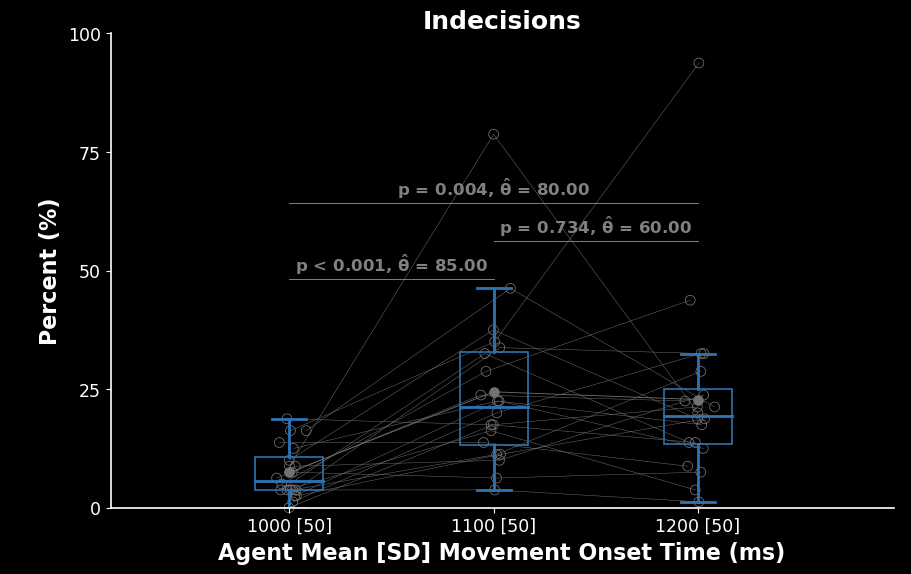

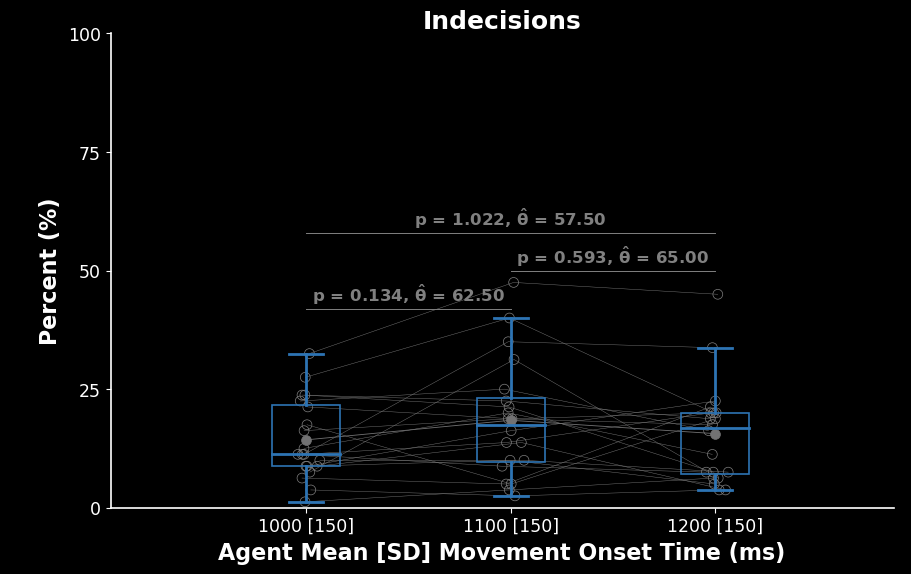

In [65]:
if experiment == 'Exp1':
    alternative = 'less'
else:
    alternative = 'two-sided'
    
indecisions_anova,indecisions_statistics = so.run_statistics('Indecisions',alternative = 'two-sided')
display(indecisions_anova)
so.plot(indecisions_statistics,'Indecisions',title='Indecisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=0,h=0.5,
                cut_pvals = False)

# Reaction Decisions

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,44393.984375,2,38,22196.992188,59.595929,1.921841e-12,6.089857e-10,0.441904,0.757397
1,Factor 2,421.875000,1,19,421.875000,2.074124,1.660912e-01,1.660912e-01,0.007468,1.000000
2,Factor 1 * Factor 2,556.953125,2,38,278.476562,1.569458,2.213525e-01,2.269731e-01,0.009836,0.637104


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


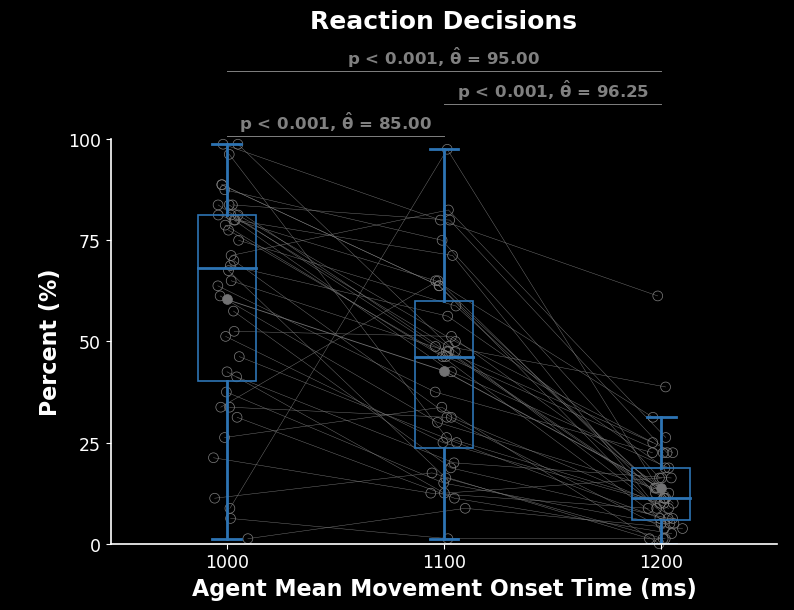

Collapsing, changed select conditions to be All


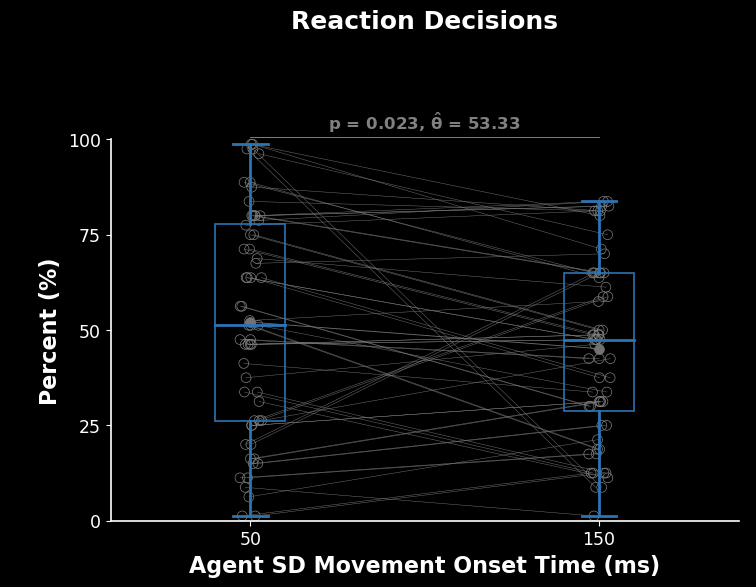

In [66]:
reactions_anova,reactions_statistics = so.run_statistics('Reaction Decisions',alternative = 'two-sided')
display(reactions_anova)
so.plot(reactions_statistics,'Reaction Decisions',title='Reaction Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,44393.984375,2,38,22196.992188,59.595929,1.921841e-12,6.089857e-10,0.441904,0.757397
1,Factor 2,421.875000,1,19,421.875000,2.074124,1.660912e-01,1.660912e-01,0.007468,1.000000
2,Factor 1 * Factor 2,556.953125,2,38,278.476562,1.569458,2.213525e-01,2.269731e-01,0.009836,0.637104


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


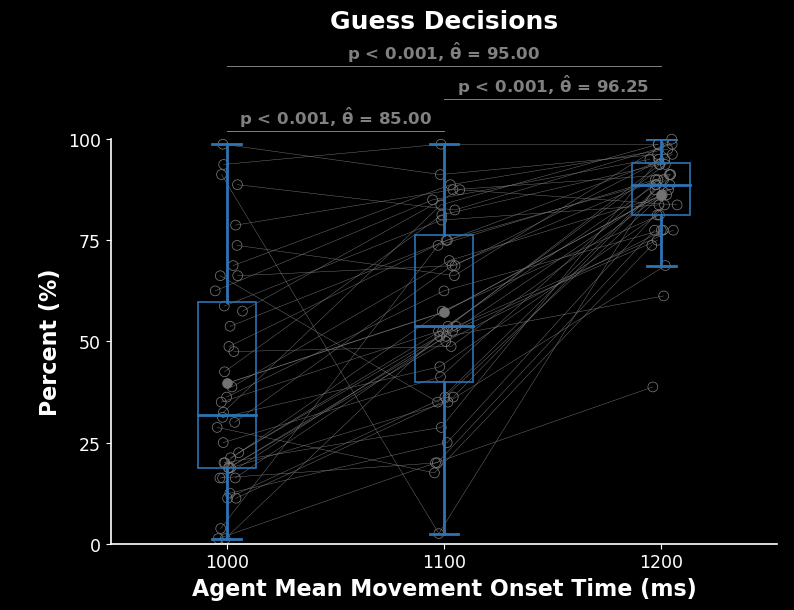

Collapsing, changed select conditions to be All


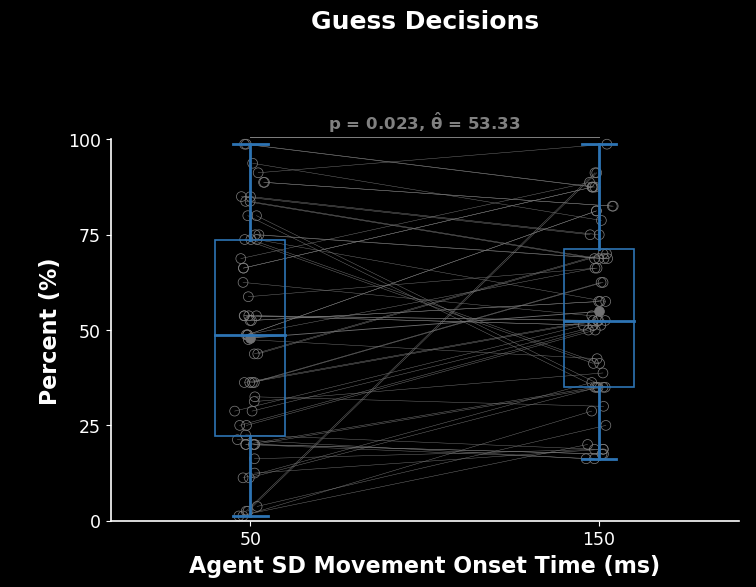

In [67]:
gambles_anova,gambles_statistics = so.run_statistics('Gamble Decisions',alternative = 'two-sided')
display(gambles_anova)
so.plot(gambles_statistics,'Gamble Decisions',title='Guess Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)